In this [experiment](G_Facial_keypoint_detection.ipynb), I implemented a convolutional neural network to detect 68 keypoints on a face, based on the starting code, instructions, utility functions and training data from Udacity's [Computer Vision](https://www.udacity.com/course/computer-vision-nanodegree--nd891) nanodegree.

The training data provided by Udacity includes thousands of facial images that come with 68 keypoints for each face (for example, eyebrows, eyes, mouth, nose bridge and jaw).

This is a regression task, and the convolutional neural network outputs 68 x, y-coordinates that should be as close as possible to the 68 ground-truth keypoints. Thus, loss function is MSE loss function. 

I used a pre-trained EfficientNet model as feature extractor, and only trained the final layers of the network to compute the keypoint coordinates based on those features.

Here's an example of 68 keypoints on sample facial images:
![key_pts_example.png](images%2Fkey_pts_example.png)

# Results

Before training, the model output 68 x- and y- coordinates but they represent random points.

![pretraining_img1.png](pretraining_img1.png)

After 45 epochs, the 68 output keypoints closely resemble the ground-truth keypoints from Udacity's dataset.

![pretraining_img2.png](pretraining_img2.png)

![pretraining_img3.png](pretraining_img3.png)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# extracting the training data into Google Collab temporary runtime folder
# because loading from this folder is significantly faster
!unzip '/content/drive/Othercomputers/My Laptop/P1_Facial_Keypoints/data.zip' -d '/content/temp';

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as I

%load_ext autoreload
%autoreload 2

# Defining the neural network

In [4]:
import torchvision.models as models

class Net(nn.Module):
  def __init__(self, img_dim=224, drop_out=0.3):
    super(Net, self).__init__()
    self.efficient_net = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V1)
    self.n_neurons_last_layer = 62720
    for name, param in self.efficient_net.features.named_parameters():
      if int(name.split('.')[0]) < 3:
        param.requires_grad = False
    self.input_img_dim = img_dim
    self.flatten = nn.Flatten()
    self.dropout = nn.Dropout(p=drop_out)
    self.fc1 = nn.Linear(in_features=self.n_neurons_last_layer, out_features=136)

  def forward(self, x):
    x = x.expand(-1, 3, -1, -1)
    x = self.efficient_net.features(x)
    x = self.flatten(x)
    x = self.dropout(x)
    # print(x.shape)
    x = self.fc1(x)
    return x

# Batching and loading data

In [5]:
%cd /content/drive/Othercomputers/My Laptop/P1_Facial_Keypoints

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from data_load import FacialKeypointsDataset
from data_load import Rescale, RandomCrop, Normalize, ToTensor

data_transform = transforms.Compose([Rescale(250), RandomCrop(224), Normalize(), ToTensor()])


/content/drive/Othercomputers/My Laptop/P1_Facial_Keypoints


In [6]:
%cd /content/temp

transformed_dataset = FacialKeypointsDataset(csv_file="data/training_frames_keypoints.csv", root_dir="data/training/", transform=data_transform)
test_dataset = FacialKeypointsDataset(csv_file="data/test_frames_keypoints.csv", root_dir="data/test/", transform=data_transform)

print(f"Number of images {len(transformed_dataset)}")
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample["image"].size(), sample["keypoints"].size())

/content/temp
Number of images 3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [7]:
batch_size = 32
train_loader = DataLoader(transformed_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [8]:
batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Visualize predicted keypoints (pre-training)

In [9]:
net = Net()

Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 54.8MB/s]


In [10]:
def test_sample_output():
    for i, sample in enumerate(test_loader):
        images = sample["image"]
        key_pts = sample["keypoints"]
        images = images.type(torch.FloatTensor)
        if torch.cuda.is_available():
            images = images.cuda()
            key_pts = key_pts.cuda()
            net.cuda()
        output_pts = net(images)
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        if i == 0:
            return images.cpu(), output_pts.cpu(), key_pts.cpu()

In [11]:
test_images, test_outputs, gt_pts = test_sample_output()
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([32, 1, 224, 224])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


In [12]:
# this function displays an image, predicted keypoints and ground-truth keypoints
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""

    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1],s=20, marker='.', c='g')


In [13]:
# this function takes in a batch of images and display the predicted keypoints (vs true keypoints) for those images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    for i in range(batch_size):
        plt.figure(figsize=(5, 5))
        image = test_images[i].data
        image = image.numpy()
        image = np.transpose(image, (1, 2, 0))  # channel-last

        # un-transform the predicted key_pts data (for proper plotting)
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints
        predicted_key_pts = predicted_key_pts * 50.0 + 100.0

        # plot ground truth points for comparison, if they exist
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]
            ground_truth_pts = ground_truth_pts * 50.0 + 100

        show_all_keypoints(image, predicted_key_pts=predicted_key_pts, gt_pts=ground_truth_pts)
        # plt.axis('off')
    plt.show()

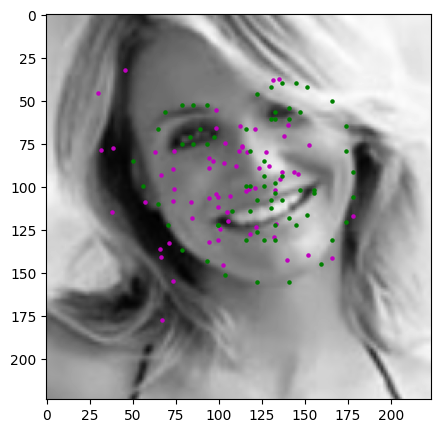

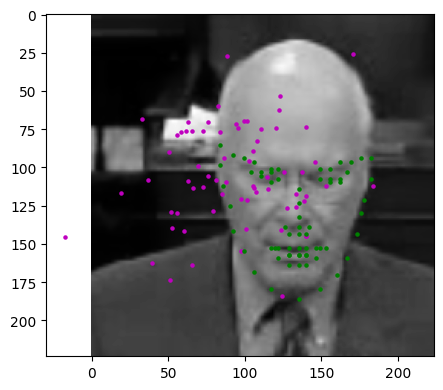

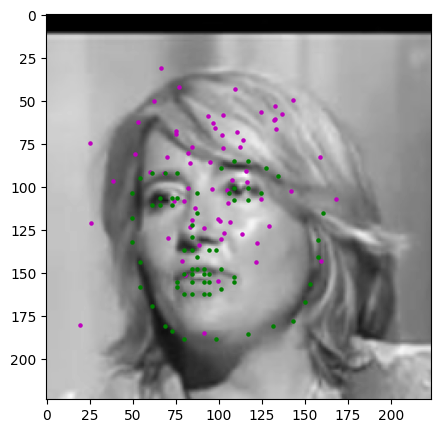

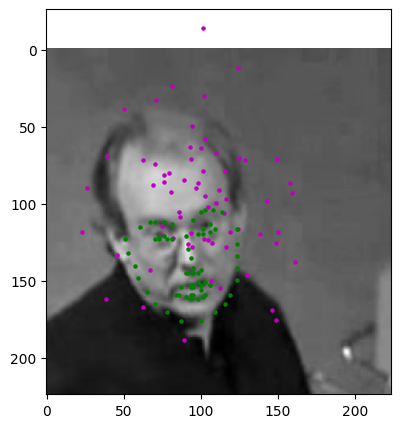

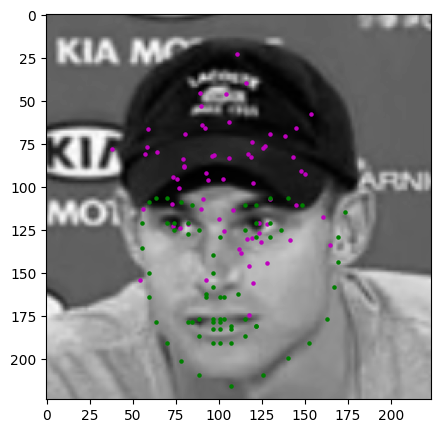

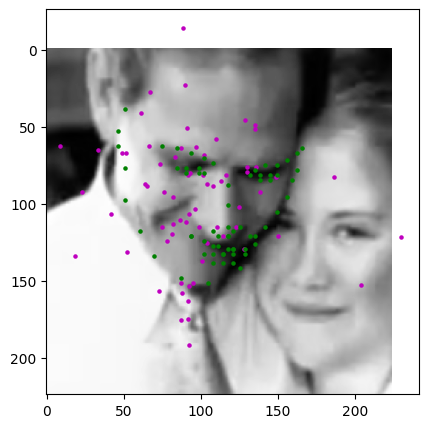

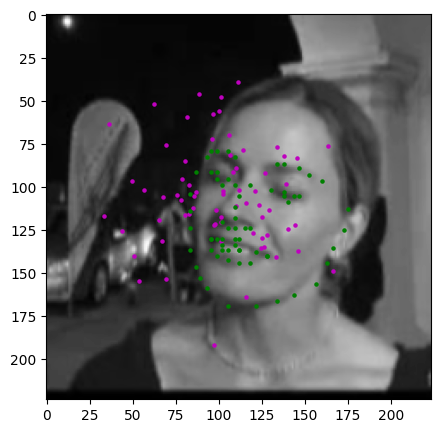

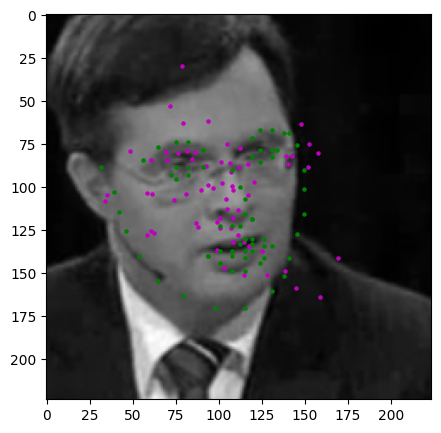

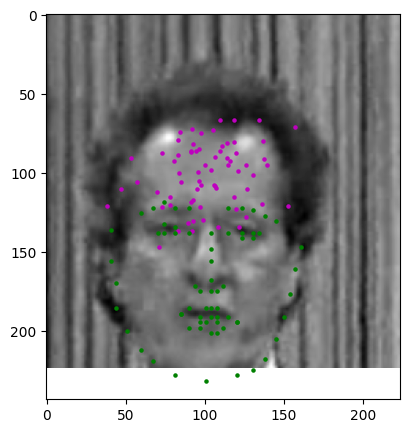

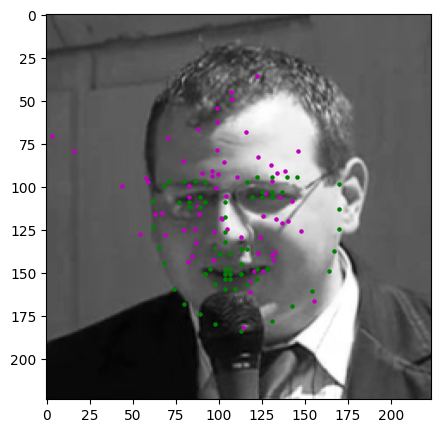

In [14]:
# we can see that an un-trained model simply outputs random keypoints (magenta) that don't correspond at all to true keypoints (green)
visualize_output(test_images=test_images.cpu(), test_outputs=test_outputs.cpu(), gt_pts=gt_pts.cpu())

# Training

In [24]:
del net
net = Net()

In [25]:
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam([
    {'params': net.efficient_net.features.parameters(), 'lr': 0.0002},
    {'params': net.fc1.parameters(), 'lr': 0.0005}
])

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, factor=0.5, threshold=0.03, min_lr=1e-5)


In [26]:
torch.cuda.is_available()

True

In [31]:
print_every_how_many_batches = 50

def train_net(n_epochs):
    train_losses_by_epoch = []
    val_losses_by_epoch = []
    # prepare the net for training
    net.train()
    net.cuda()
    # loop over the dataset multiple times
    for epoch in range(n_epochs):
        net.train()
        running_loss = 0.0
        current_epoch_loss = 0.0
        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images, key_pts = data["image"], data["keypoints"]
            # flatten pts (so can compare to the output of neural network)
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            key_pts = key_pts.cuda()
            images = images.cuda()
             # zero grad
            optimizer.zero_grad()
            # forward pass
            outputs = net(images)
            # calculate the loss
            loss = criterion(outputs, key_pts)
            # # zero grad
            # backward
            loss.backward()
            # update the weights
            optimizer.step()
            # scheduler.step(metrics=loss.item())
            # print loss statistics
            running_loss += loss.item()
            current_epoch_loss += loss.item()
            if batch_i % print_every_how_many_batches == print_every_how_many_batches - 1:
                # print(f"Epoch {epoch+1}...Batch {batch_i+1}...Loss per batch {running_loss / print_every_how_many_batches:.4f}")
                running_loss = 0

        train_loss_per_batch = current_epoch_loss / len(train_loader)
        train_losses_by_epoch.append(current_epoch_loss)
        print(f"Epoch {epoch+1}...Training loss per batch {train_loss_per_batch:.4f}")

        with torch.no_grad():
            net.eval()
            val_loss = 0
            for batch_i, data in enumerate(test_loader):
                images, key_pts = data["image"], data["keypoints"]
                key_pts = key_pts.view(key_pts.size(0), -1)
                key_pts = key_pts.type(torch.FloatTensor)
                images = images.type(torch.FloatTensor)
                key_pts = key_pts.cuda()
                images = images.cuda()
                outputs = net(images)
                val_batch_loss = criterion(outputs, key_pts)
                val_loss += val_batch_loss
            val_loss_per_batch = val_loss / len(test_loader)
            print(f"Epoch {epoch+1}...Val loss per batch {val_loss_per_batch:.4f}")
            scheduler.step(metrics=val_loss.item())
            val_losses_by_epoch.append(val_loss)

    return train_losses_by_epoch, val_losses_by_epoch
    print("Finished training")

In [32]:
len(train_loader)

109

In [33]:
n_epochs = 45
train_losses, val_losses = train_net(n_epochs)

Epoch 1...Training loss per batch 0.3257
Epoch 1...Val loss per batch 0.1828
Epoch 2...Training loss per batch 0.2495
Epoch 2...Val loss per batch 0.1670
Epoch 3...Training loss per batch 0.2037
Epoch 3...Val loss per batch 0.1274
Epoch 4...Training loss per batch 0.1691
Epoch 4...Val loss per batch 0.1056
Epoch 5...Training loss per batch 0.1407
Epoch 5...Val loss per batch 0.0881
Epoch 6...Training loss per batch 0.1205
Epoch 6...Val loss per batch 0.0877
Epoch 7...Training loss per batch 0.1184
Epoch 7...Val loss per batch 0.0672
Epoch 8...Training loss per batch 0.0974
Epoch 8...Val loss per batch 0.0706
Epoch 9...Training loss per batch 0.0974
Epoch 9...Val loss per batch 0.0601
Epoch 10...Training loss per batch 0.0949
Epoch 10...Val loss per batch 0.0608
Epoch 11...Training loss per batch 0.0915
Epoch 11...Val loss per batch 0.0666
Epoch 12...Training loss per batch 0.0839
Epoch 12...Val loss per batch 0.0484
Epoch 13...Training loss per batch 0.0743
Epoch 13...Val loss per batc

In [34]:
# checking the results on training batch
def feed_one_training_batch():
    for i, sample in enumerate(train_loader):
        net.eval()
        images_train = sample["image"]
        key_pts_train = sample["keypoints"]
        images_train = images_train.type(torch.FloatTensor)
        if torch.cuda.is_available():
            images_train = images_train.cuda()
            key_pts_train = key_pts_train.cuda()
            net.cuda()
        output_pts_train = net(images_train)
        output_pts_train = output_pts_train.view(output_pts_train.size()[0], 68, -1)
        if i == 0:
            return images_train.cpu(), output_pts_train.cpu(), key_pts_train.cpu()



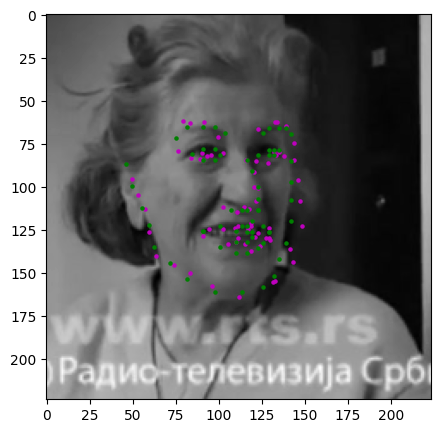

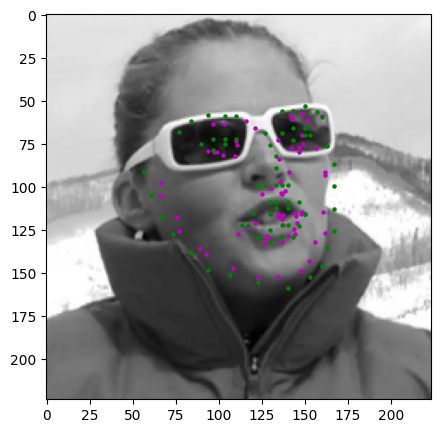

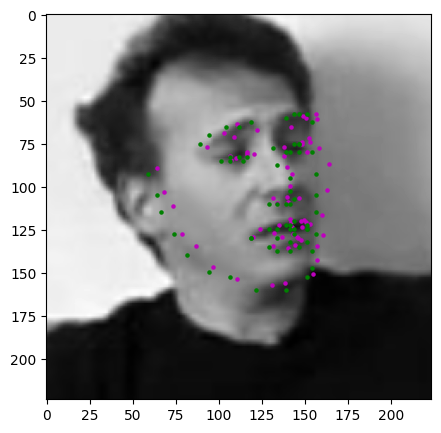

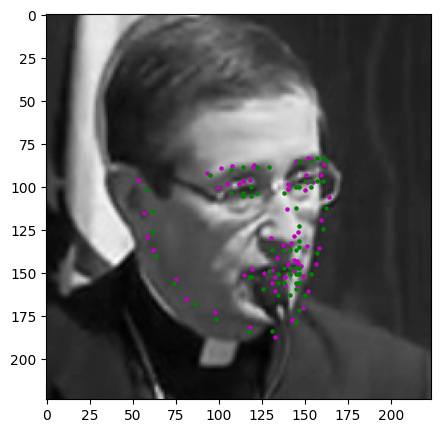

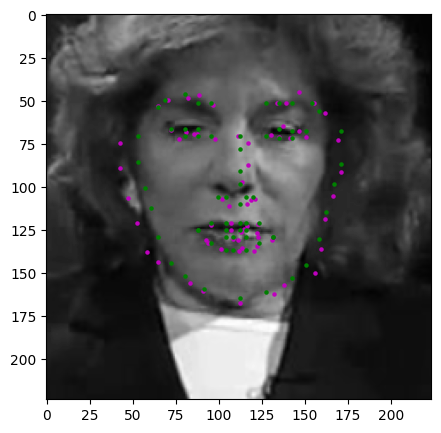

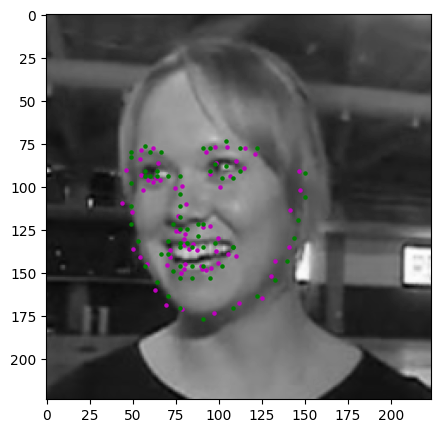

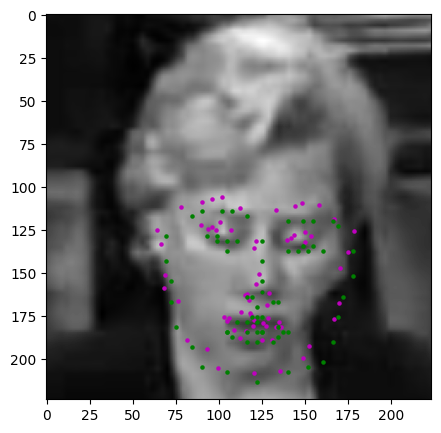

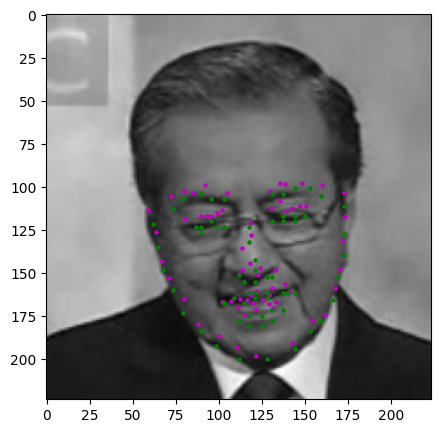

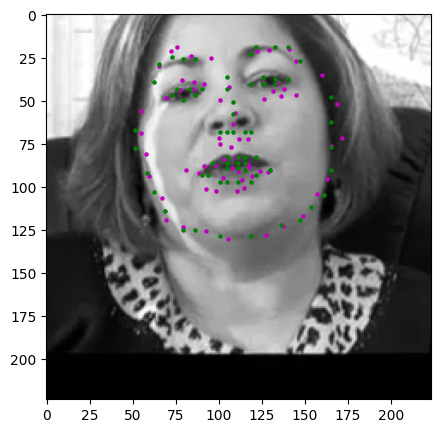

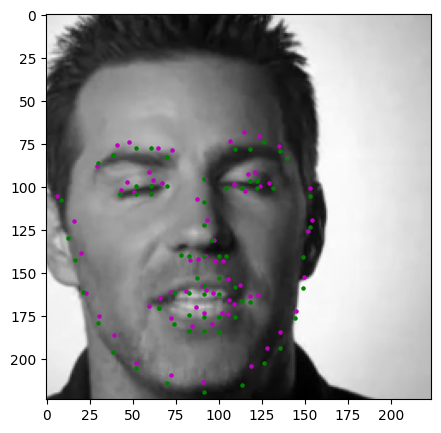

In [35]:
images_train, output_pts_train, key_pts_train = feed_one_training_batch()
visualize_output(images_train, output_pts_train, key_pts_train)

# Visualize keypoints on test images

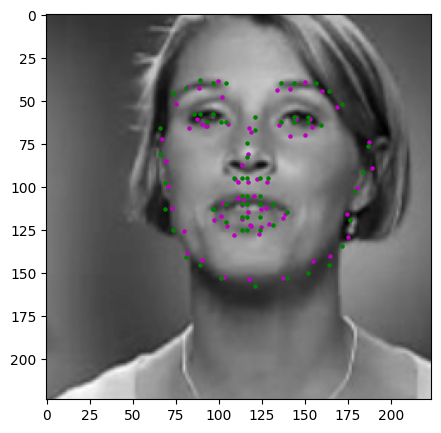

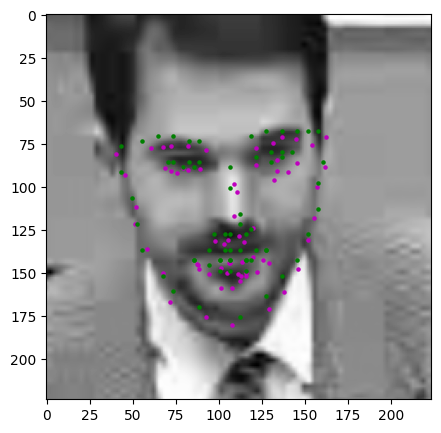

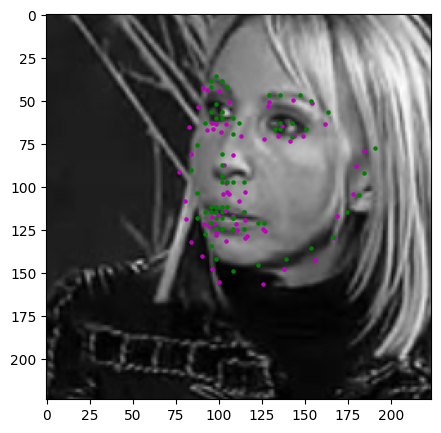

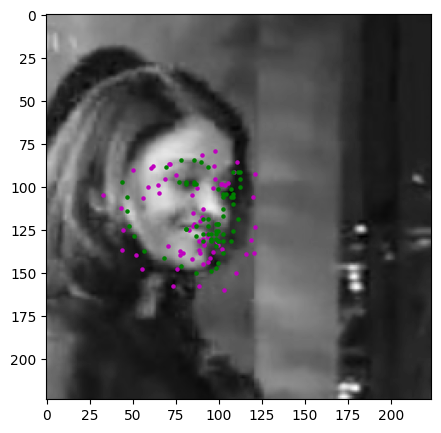

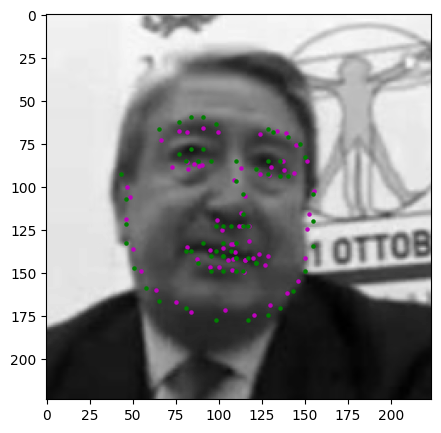

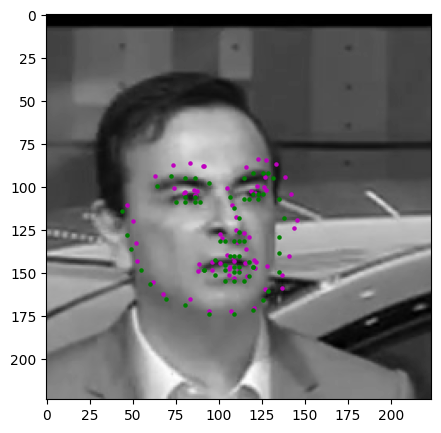

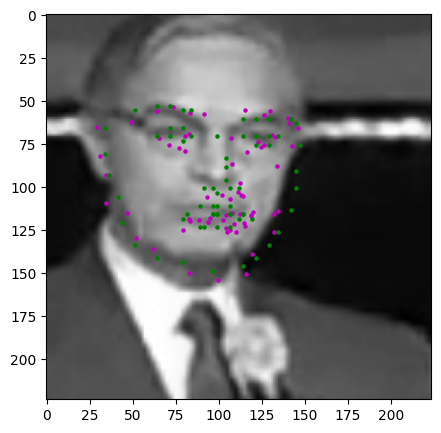

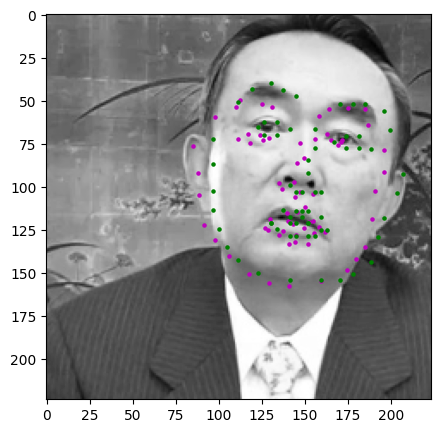

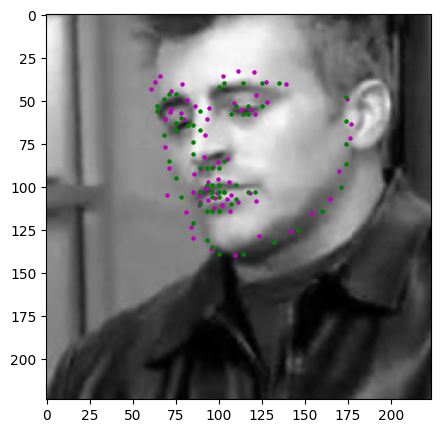

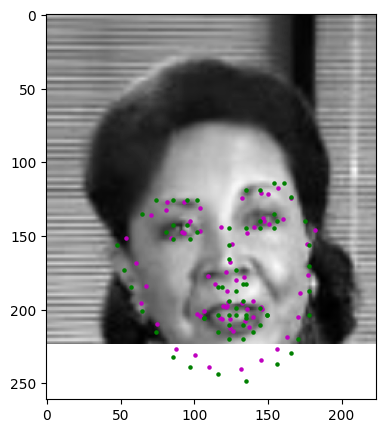

In [ ]:
test_images, test_outputs, gt_pts = net_sample_output()
visualize_output(test_images.cpu(), test_outputs.cpu(), gt_pts.cpu())

In [ ]:
%cd /content/drive/Othercomputers/My Laptop/P1_Facial_Keypoints
model_dir = "saved_models/"
model_name = "keypoints_model_1.pt"
torch.save(net.state_dict(), model_dir+model_name)